In [1]:
%reset
import os

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import pandas as pd
%pylab inline

original_data =   pd.read_csv('2015-building-energy-benchmarking_selected.csv', sep=',', index_col=[0])

data = original_data.copy()
data = data[data["SiteEnergyUseWN(kBtu)"]<5e7]

Populating the interactive namespace from numpy and matplotlib


In [2]:
id_col = ['PropertyName']

des_col = ['CouncilDistrictCode','Neighborhood','BuildingType',
           'LargestPropertyUseType', 'SecondLargestPropertyUseType', 
           'ThirdLargestPropertyUseType','PrimaryPropertyType']

q_col = ['YearBuilt', 'PropertyGFATotal', 
         'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 
         'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 
        ]

y_col = ['SiteEnergyUseWN(kBtu)']

# Step before regression

## Expand categorical columns

In [3]:
new_col = []

for col in des_col:
    dataframe = pd.get_dummies(data[col],prefix=col)
    new_col.extend(dataframe.columns)
    data = data.join(dataframe)
    data.drop(col, axis=1, inplace=True)

print('created columns number:', len(new_col))

created columns number: 199


## Create X and y

In [4]:
X = data[q_col+new_col]
y = data[y_col]

## Split in train-test

In [5]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=100, test_size=0.3)

## Rescale data

In [6]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

## Create quantify error function

In [7]:
from sklearn import metrics
from sklearn.preprocessing import minmax_scale

def quantify_error(_y_true, _y_pred):
    metrics_df = pd.DataFrame(columns=['MAE', 'RMSE', 'RMSLE', 'MAPE', 'R2'], index=[0])
    metrics_df.at[0,'MAE'] = metrics.mean_absolute_error(_y_true, _y_pred)
    metrics_df.at[0,'RMSE'] = np.sqrt(metrics.mean_squared_error(_y_true, _y_pred))
    y_true_norm = minmax_scale(_y_true, feature_range=(0,1))
    y_pred_norm = minmax_scale(_y_pred, feature_range=(0,1))
    metrics_df.at[0,'RMSLE'] = np.sqrt(metrics.mean_squared_log_error(y_true_norm, y_pred_norm))
    metrics_df.at[0,'MAPE'] = metrics.mean_absolute_percentage_error(_y_true, _y_pred)
    metrics_df.at[0,'R2'] = metrics.r2_score(_y_true, _y_pred)
    return metrics_df

In [8]:
# Create errors dataframe
errors_df = pd.DataFrame(columns=['MAE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])

# Regression

## Dummy regressor

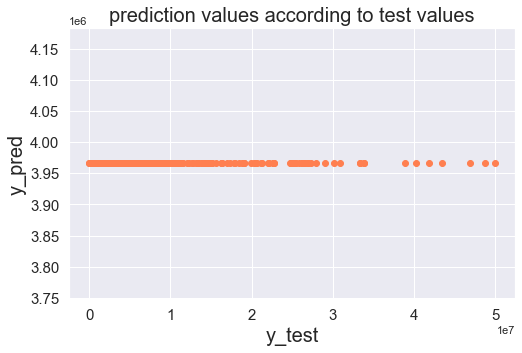

In [9]:
from sklearn.dummy import DummyRegressor
import seaborn as sns
sns.set(style="darkgrid")

# Create Regressor object
dummy_regr = DummyRegressor(strategy="mean")

# Create model by fitting train data
dummy_regr.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = dummy_regr.predict(X_test_std)

# Get metrics errors
errors_df.loc['DummyRegressor'] = quantify_error(y_test, y_pred).loc[0]
    
# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

## knn solver

MAE      2.229375e+06
RMSE     4.659462e+06
RMSLE    8.646256e-02
MAPE     6.503671e+19
R2       4.601609e-01
Name: KnnSolver, dtype: float64


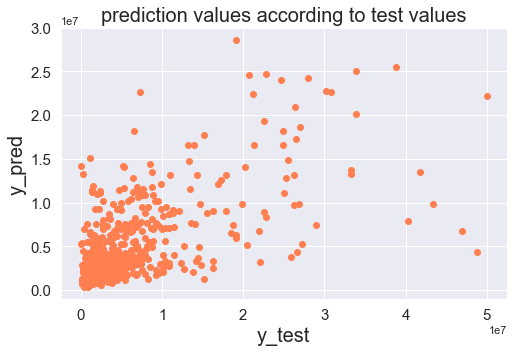

In [10]:
from sklearn import neighbors
import seaborn as sns
sns.set(style="darkgrid")

# Create Regressor object
knn = neighbors.KNeighborsRegressor(n_neighbors=5)

# Create model by fitting train data
knn.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = knn.predict(X_test_std)

# Get metrics errors
errors_df.loc['KnnSolver'] = quantify_error(y_test, y_pred).loc[0]

print(errors_df.loc['KnnSolver'])

# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

## Linear regression

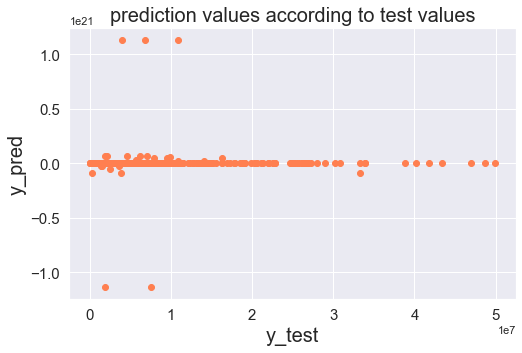

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set(style="darkgrid")

# Create Regressor object
lr = LinearRegression()

# Fit model using train data
lr.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = lr.predict(X_test_std)

# Get metrics errors
errors_df.loc['LinearRegression'] = quantify_error(y_test, y_pred).loc[0]

# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

## Ridge regression

The optimal parameters are :
             0
alpha 1274.27 

 with a score of 0.54


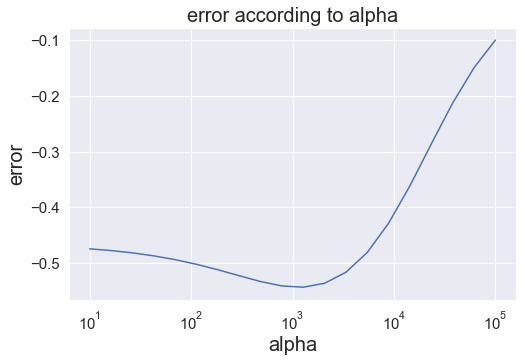

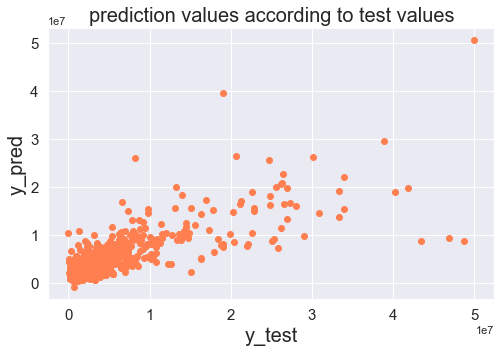

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set(style="darkgrid")

# Create hyperparameters dict to find best value for each parameter
params = {'alpha': np.logspace(1, 5, 20), 
         }

# Apply Grid Search CV to search over algorithm parameters
gs_ridge = GridSearchCV(Ridge(max_iter=2000), params, cv=10, scoring='r2', n_jobs=-1)
gs_ridge.fit(X_train_std, y_train.values.ravel())

with pd.option_context('display.float_format', '{:.2f}'.format):
    print("The optimal parameters are :\n {} \n\n with a score of {:.2f}".format(
                                    pd.DataFrame.from_dict(gs_ridge.best_params_, orient='index'), 
                                    gs_ridge.best_score_))

# Display error according to alpha parameter
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(gs_ridge.cv_results_['param_alpha'], -gs_ridge.cv_results_['mean_test_score'])
ax.set_xscale('log')
plt.xlabel("alpha", fontsize=20)
plt.ylabel("error", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('error according to alpha', fontsize=20)
plt.show()

# Predict on test data using best parameter
y_pred = gs_ridge.predict(X_test_std)

# Get metrics errors
errors_df.loc['Ridge_grid'] = quantify_error(y_test, y_pred).loc[0]

# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

In [14]:
from sklearn.linear_model import Ridge

# Create Regressor object
ridge = Ridge(alpha=1e3)

# Create model by fitting train data
ridge.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = ridge.predict(X_test_std)

# Get metrics errors
errors_df.loc['Ridge'] = quantify_error(y_test, y_pred).loc[0]
print(errors_df.loc['Ridge'])

MAE      1.898548e+06
RMSE     3.910845e+06
RMSLE    6.230380e-02
MAPE     4.753073e+19
R2       6.196933e-01
Name: Ridge, dtype: float64


## Lasso regression

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0179753083412164e+16, tolerance: 7366080526212.666
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0459681135603028e+16, tolerance: 7332619435412.208
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0226769721836896e+16, tolerance: 7157283527741.978
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Co

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8998420611926504.0, tolerance: 7384611759622.167
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9158390446919320.0, tolerance: 7210883570225.503
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6657115188922261.0, tolerance: 7366080526212.666
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2336725354627112.0, tolerance: 7143401009692.373
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313621256991290.0, tolerance: 7384611759622.167
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2795491473246068.0, tolerance: 6961471974883.513
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36609024817616.0, tolerance: 6961471974883.513
  model = cd_fast.enet_coordinate_descent(


The optimal parameters are :
               0
alpha 100000.00 

 with a score of 0.53


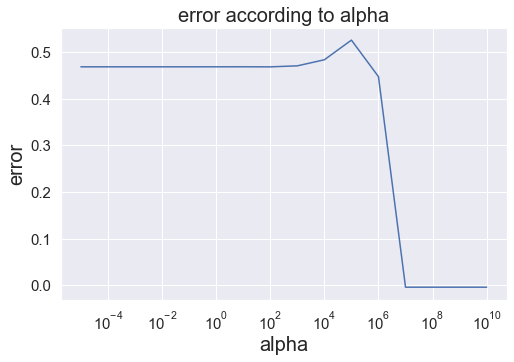

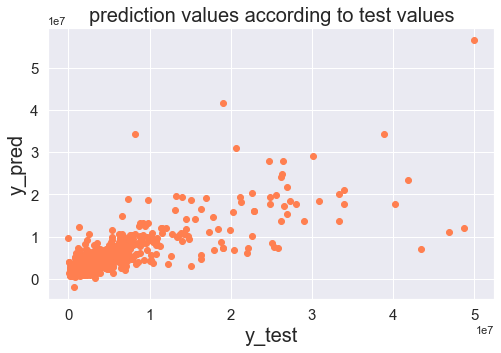

In [15]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set(style="darkgrid")

# Create hyperparameters dict to find best value for each parameter
params = {'alpha': np.logspace(-5, 10, 16), 
         }

# Apply Grid Search CV to search over algorithm parameters
gs_lasso = GridSearchCV(Lasso(max_iter=2000), params, cv=10, scoring='r2', n_jobs=-1)
gs_lasso.fit(X_train_std, y_train.values.ravel())

with pd.option_context('display.float_format', '{:.2f}'.format):
    print("The optimal parameters are :\n {} \n\n with a score of {:.2f}".format(
                                    pd.DataFrame.from_dict(gs_lasso.best_params_, orient='index'), 
                                    gs_lasso.best_score_))

# Display error according to alpha parameter
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(gs_lasso.cv_results_['param_alpha'], gs_lasso.cv_results_['mean_test_score'])
ax.set_xscale('log')
plt.xlabel("alpha", fontsize=20)
plt.ylabel("error", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('error according to alpha', fontsize=20)
plt.show()

# Predict on test data using best parameter
y_pred = gs_lasso.predict(X_test_std)

# Get metrics errors
errors_df.loc['Lasso_grid'] = quantify_error(y_test, y_pred).loc[0]

# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

In [16]:
from sklearn.linear_model import Lasso

# Create Regressor object
lasso = Lasso(alpha=1e6)

# Create model by fitting train data
lasso.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = lasso.predict(X_test_std)

# Get metrics errors
errors_df.loc['Lasso'] = quantify_error(y_test, y_pred).loc[0]

print(errors_df.loc['Lasso'])

MAE      2.252092e+06
RMSE     4.217297e+06
RMSLE    6.851533e-02
MAPE     3.203777e+19
R2       5.577568e-01
Name: Lasso, dtype: float64


## ElasticNet

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1495134271582026e+16, tolerance: 7157283527741.978
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0907979704695808e+16, tolerance: 7143401009692.373
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1756278974475962e+16, tolerance: 7332619435412.208
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Co

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8042505356321896e+16, tolerance: 6961471974883.513
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8499324021903264e+16, tolerance: 7210883570225.503
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.382442676502719e+16, tolerance: 6961471974883.513
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Con

The optimal parameters are :
             0
alpha    1.00
l1_ratio 0.40 

 with a score of 0.54


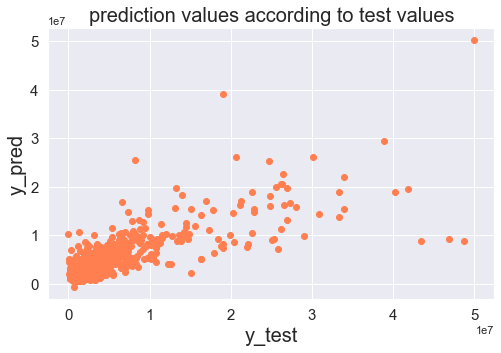

In [17]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set(style="darkgrid")

# Create hyperparameters dict to find best value for each parameter
params = {'alpha': np.logspace(-1, 3, 5), 
          'l1_ratio' : np.arange(0, 1, 0.1).tolist()
         }
# Apply Grid Search CV to search over algorithm parameters
gs_elastic = GridSearchCV(ElasticNet(), params, cv=10, scoring='r2', n_jobs=-1)
gs_elastic.fit(X_train_std, y_train.values.ravel())

with pd.option_context('display.float_format', '{:.2f}'.format):
    print("The optimal parameters are :\n {} \n\n with a score of {:.2f}".format(
                                    pd.DataFrame.from_dict(gs_elastic.best_params_, orient='index'), 
                                    gs_elastic.best_score_))

# Predict on test data using best parameter
y_pred = gs_elastic.predict(X_test_std)

# Get metrics errors
errors_df.loc['ElasticNet_grid'] = quantify_error(y_test, y_pred).loc[0]

# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

In [18]:
from sklearn.linear_model import ElasticNet

# Create Regressor object
elastic_net = ElasticNet(alpha=1, l1_ratio=0.4)

# Create model by fitting train data
elastic_net.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = elastic_net.predict(X_test_std)

# Get metrics errors
errors_df.loc['ElasticNet'] = quantify_error(y_test, y_pred).loc[0]
print(errors_df.loc['ElasticNet'])

MAE      1.908710e+06
RMSE     3.913581e+06
RMSLE    6.007024e-02
MAPE     4.705635e+19
R2       6.191611e-01
Name: ElasticNet, dtype: float64


## SVR

The optimal parameters are :
                0
C       21544.35
degree         1
epsilon     0.00
kernel    linear 

 with a score of 0.55


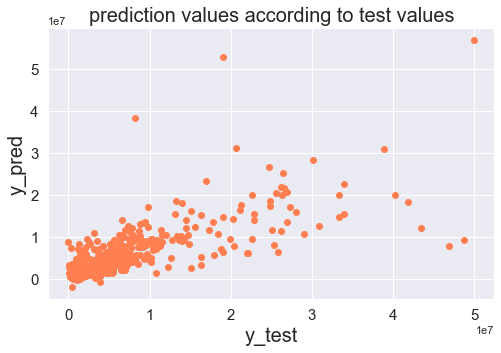



0

In [19]:
from sklearn.svm import SVR
import seaborn as sns
sns.set(style="darkgrid")

# Create hyperparameters dict to find best value for each parameter
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'degree':list(range(1,3)),
          'C': np.logspace(1,6,7),
          'epsilon': np.logspace(-3,0,4),
         }

# Apply Grid Search CV to search over algorithm parameters
gs_svr = GridSearchCV(SVR(), params, cv=10, scoring='r2', n_jobs=-1)
gs_svr.fit(X_train_std, y_train.values.ravel())

with pd.option_context('display.float_format', '{:.2f}'.format):
    print("The optimal parameters are :\n {} \n\n with a score of {:.2f}".format(
                                    pd.DataFrame.from_dict(gs_svr.best_params_, orient='index'), 
                                    gs_svr.best_score_))

# Predict on test data using best parameter
y_pred = gs_svr.predict(X_test_std)

# Get metrics errors
errors_df.loc['SVR_grid'] = quantify_error(y_test, y_pred).loc[0]

# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

os.system("printf '\7'")

In [20]:
from sklearn.svm import SVR

# Create Regressor object
svr = SVR(C=2e4, kernel='linear')

# Create model by fitting train data
svr.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = svr.predict(X_test_std)

# Get metrics errors
errors_df.loc['SVR'] = quantify_error(y_test, y_pred).loc[0]

print(errors_df.loc['SVR'])

MAE      1.728251e+06
RMSE     4.009598e+06
RMSLE    6.156782e-02
MAPE     4.043452e+19
R2       6.002445e-01
Name: SVR, dtype: float64


## Linear SVR

The optimal parameters are :
            0
C       0.00
epsilon 0.10 

 with a score of 0.50


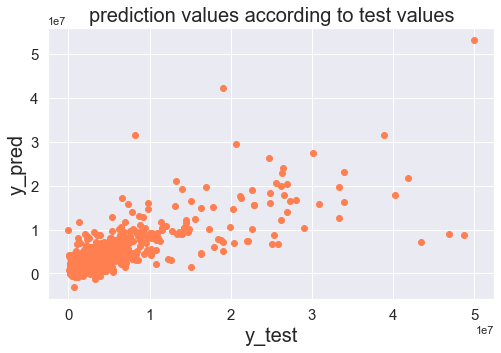



0

In [21]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

# Create hyperparameters dict to find best value for each parameter
params = {'epsilon': np.logspace(-1, 2, 4),
          'C': np.logspace(-5, -1, 5),
         }

# Apply Grid Search CV to search over algorithm parameters
gs_lsvr = GridSearchCV(LinearSVR(max_iter=2000, loss='squared_epsilon_insensitive'), 
                       params, cv=10, scoring='r2', n_jobs=-1)
gs_lsvr.fit(X_train_std, y_train.values.ravel())

with pd.option_context('display.float_format', '{:.2f}'.format):
    print("The optimal parameters are :\n {} \n\n with a score of {:.2f}".format(
                                    pd.DataFrame.from_dict(gs_lsvr.best_params_, orient='index'), 
                                    gs_lsvr.best_score_))

# Predict on test data using best parameter
y_pred = gs_lsvr.predict(X_test_std)

# Get metrics errors
errors_df.loc['LinearSVR_grid'] = quantify_error(y_test, y_pred).loc[0]

# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

os.system("printf '\7'")

In [22]:
from sklearn.svm import LinearSVR

# Create Regressor object
linear_SVR = LinearSVR(C=1e-3, epsilon=1e2, loss='squared_epsilon_insensitive')

# Create model by fitting train data
linear_SVR.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = linear_SVR.predict(X_test_std)

# Get metrics errors
errors_df.loc['LinearSVR'] = quantify_error(y_test, y_pred).loc[0]
print(errors_df.loc['LinearSVR'])

MAE      1.938629e+06
RMSE     4.021660e+06
RMSLE    6.795254e-02
MAPE     4.471102e+19
R2       5.978356e-01
Name: LinearSVR, dtype: float64


## Regression ridge à noyau

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/l

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/l

The optimal parameters are :
            0
alpha   2.15
degree     2
kernel  poly 

 with a score of 0.56


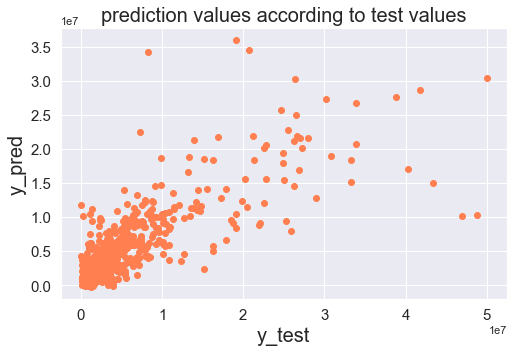



0

In [23]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

# Create hyperparameters dict to find best value for each parameter
params = {'alpha': np.logspace(-1, 1, 4),
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'degree':list(range(1,3)),
         }

# Apply Grid Search CV to search over algorithm parameters
grid_kernel_ridge = GridSearchCV(KernelRidge(), params, cv=10, scoring='r2', n_jobs=-1)
grid_kernel_ridge.fit(X_train_std, y_train.values.ravel())

with pd.option_context('display.float_format', '{:.2f}'.format):
    print("The optimal parameters are :\n {} \n\n with a score of {:.2f}".format(
                                    pd.DataFrame.from_dict(grid_kernel_ridge.best_params_, orient='index'), 
                                    grid_kernel_ridge.best_score_))

# Predict on test data using best parameter
y_pred = grid_kernel_ridge.predict(X_test_std)

# Get metrics errors
errors_df.loc['KernelRidge_grid'] = quantify_error(y_test, y_pred).loc[0]

# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

os.system("printf '\7'")

In [24]:
from sklearn.kernel_ridge import KernelRidge

# Create Regressor object
kernel_ridge = KernelRidge(alpha=2, degree=2, kernel='poly')

# Create model by fitting train data
kernel_ridge.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = kernel_ridge.predict(X_test_std)

# Get metrics errors
errors_df.loc['KernelRidge'] = quantify_error(y_test, y_pred).loc[0]
print(errors_df.loc['KernelRidge'])

MAE      1.786506e+06
RMSE     3.740676e+06
RMSLE    6.892025e-02
MAPE     5.436092e+19
R2       6.520690e-01
Name: KernelRidge, dtype: float64


## Bagging regressor

MAE      1.732035e+06
RMSE     3.589152e+06
RMSLE    6.401865e-02
MAPE     5.226567e+19
R2       6.796855e-01
Name: Bagging, dtype: float64


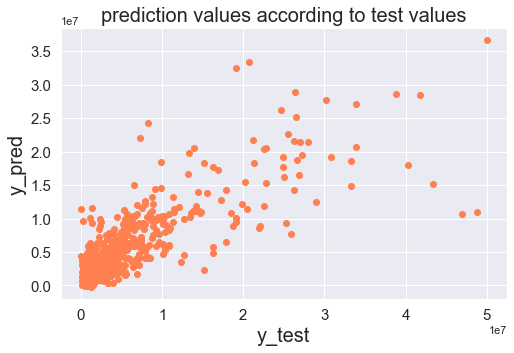

In [26]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import BaggingRegressor

# Create Bagging Regressor model using SVR estimator with best parameters found earlier
bagging = BaggingRegressor(base_estimator=KernelRidge(alpha=2, degree=2, kernel='poly'), \
                           n_estimators=1000, n_jobs=-1)
# Fit model using train data
bagging.fit(X_train_std, y_train.values.ravel())

# Predict on test data using model
y_pred = bagging.predict(X_test_std)

# Get metrics errors
errors_df.loc['Bagging'] = quantify_error(y_test, y_pred).loc[0]

print(errors_df.loc['Bagging'])

# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

## Random Forest

The optimal parameters are :
                                      0
ccp_alpha                 1.778279e+08
min_samples_leaf          1.000000e-12
min_samples_split         1.000000e-12
min_weight_fraction_leaf  1.000000e-12 

 with a score of 6.16e-01
MAE      1.604947e+06
RMSE     3.515712e+06
RMSLE    7.222785e-02
MAPE     6.129392e+19
R2       6.926598e-01
Name: RandomForest_grid, dtype: float64


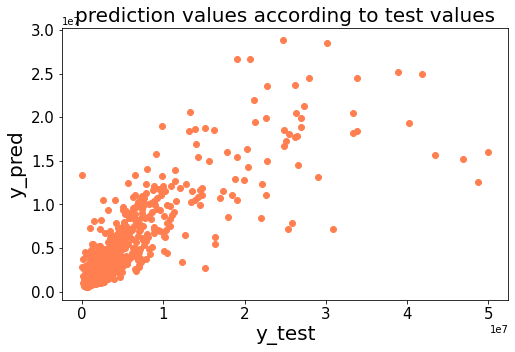

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create hyperparameters dict to find best value for each parameter
params = {
          #'max_depth': np.logspace(1,3,3),
          'min_samples_split': np.logspace(-12,-8,5),
          'min_samples_leaf':np.logspace(-12,-8,5),
          'min_weight_fraction_leaf':np.logspace(-12,-8,5),
          #'max_features':['auto', 'sqrt', 'log2'],
          'ccp_alpha':np.logspace(3,10,5),
          #'max_samples':np.arange(0.09, 1, 0.1).tolist(),
         }

# Apply Grid Search CV to search over algorithm parameters
random_forest_grid = GridSearchCV(
            RandomForestRegressor(random_state=0, 
                                  n_jobs=-1, 
                                  n_estimators=100,
                                  max_depth=100,
                                  min_samples_split=1e-10,
                                  min_samples_leaf=1e-10,
                                  min_weight_fraction_leaf=1e-10,
                                  max_features='sqrt',
                                  ccp_alpha=1e8,
                                  max_samples=0.89), 
            params, cv=10, scoring='r2')
random_forest_grid.fit(X_train_std, y_train.values.ravel())

print("The optimal parameters are :\n {} \n\n with a score of {:.2e}".format(
                 pd.DataFrame.from_dict(random_forest_grid.best_params_, orient='index'), 
                 random_forest_grid.best_score_))

# Predict on test data using best parameter
y_pred = random_forest_grid.predict(X_test_std)

# Get metrics errors
errors_df.loc['RandomForest_grid'] = quantify_error(y_test, y_pred).loc[0]

print(errors_df.loc['RandomForest_grid'])

# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

In [10]:
from sklearn.ensemble import RandomForestRegressor

# Create Regressor object
random_forest = RandomForestRegressor(random_state=0, 
                                  n_jobs=-1, 
                                  n_estimators=100,
                                  max_depth=100,
                                  min_samples_split=1e-10,
                                  min_samples_leaf=1e-10,
                                  min_weight_fraction_leaf=1e-10,
                                  max_features='sqrt',
                                  ccp_alpha=1e8,
                                  max_samples=0.89)

# Create model by fitting train data
random_forest.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = random_forest.predict(X_test_std)

# Get metrics errors
errors_df.loc['RandomForest'] = quantify_error(y_test, y_pred).loc[0]
print(errors_df.loc['RandomForest'])

MAE      1.604837e+06
RMSE     3.515717e+06
RMSLE    7.261884e-02
MAPE     6.131325e+19
R2       6.926589e-01
Name: RandomForest, dtype: float64


## Gradient Boosting

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeW

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:6

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: R

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeW

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression

  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/li

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: R

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeW

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: Ru

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: R

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:373: RuntimeWarning: overflow encountered in multiply
  lin_loss = np.sum(gamma * sample_weight[~gamma_mask] *
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression

The optimal parameters are :
                    0
alpha           0.20
learning_rate   0.32
loss           huber
max_features    sqrt 

 with a score of 0.61
MAE      1.715044e+06
RMSE     4.017218e+06
RMSLE    6.154366e-02
MAPE     4.422423e+19
R2       5.987237e-01
Name: GradientBoost_grid, dtype: float64


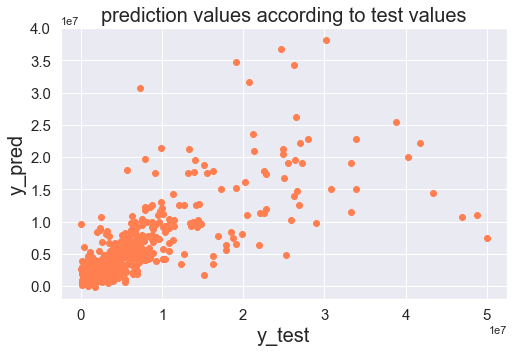

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

# Create hyperparameters dict to find best value for each parameter
params = {'learning_rate': np.logspace(-3, 2, 5),
          'loss': ['huber', 'quantile'],
          'max_features': ['auto', 'sqrt', 'log2'],
          'alpha':np.arange(0.2, 1, 0.2).tolist()
         }

# Apply Grid Search CV to search over algorithm parameters
grid_gradient_boost = GridSearchCV(GradientBoostingRegressor(random_state=0), 
                                   params, cv=10, scoring='r2', n_jobs=-1)
grid_gradient_boost.fit(X_train_std, y_train.values.ravel())

with pd.option_context('display.float_format', '{:.2f}'.format):
    print("The optimal parameters are :\n {} \n\n with a score of {:.2f}".format(
                                    pd.DataFrame.from_dict(grid_gradient_boost.best_params_, orient='index'), 
                                    grid_gradient_boost.best_score_))
    
# Predict on test data using best parameter
y_pred = grid_gradient_boost.predict(X_test_std)

# Get metrics errors
errors_df.loc['GradientBoost_grid'] = quantify_error(y_test, y_pred).loc[0]

print(errors_df.loc['GradientBoost_grid'])

# Plot predicted data according to test data 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.scatter(y_test, y_pred, color='coral')
plt.xlabel("y_test", fontsize=20)
plt.ylabel("y_pred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('prediction values according to test values', fontsize=20)
plt.show()

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

# Create Regressor object
gradient_boost = GradientBoostingRegressor(alpha=0.8, learning_rate=0.32, loss='huber', max_features='sqrt')

# Create model by fitting train data
gradient_boost.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = gradient_boost.predict(X_test_std)

# Get metrics errors
errors_df.loc['GradientBoost_p'] = quantify_error(y_test, y_pred).loc[0]

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

# Create Regressor object
gradient_boost = GradientBoostingRegressor()

# Create model by fitting train data
gradient_boost.fit(X_train_std, y_train.values.ravel())
# Predict on test data using model
y_pred = gradient_boost.predict(X_test_std)

# Get metrics errors
errors_df.loc['GradientBoost'] = quantify_error(y_test, y_pred).loc[0]

# Summary

In [16]:
with pd.option_context('display.float_format', '{:.2e}'.format):
    print(errors_df)

                        MAE     RMSE    RMSLE     MAPE       R2
RandomForest       1.60e+06 3.52e+06 7.26e-02 6.13e+19 6.93e-01
Ridge_grid         1.91e+06 3.91e+06 6.06e-02 4.72e+19 6.20e-01
GradientBoost_grid 1.72e+06 4.02e+06 6.15e-02 4.42e+19 5.99e-01
GradientBoost_p    1.68e+06 3.82e+06 5.84e-02 4.72e+19 6.37e-01
GradientBoost      1.71e+06 3.67e+06 5.56e-02 4.58e+19 6.64e-01
